## SINDy Predator-prey

In [1]:
import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
p=[1, 2, 3, 4] # Predator-prey parameters
t_start = 0
t_end = 90
num_steps = 1000

dt = (t_end-t_start)/num_steps
t = np.arange(t_start, t_end, dt)
x0 = [1, 2]
t_span = (t_start, t_end)

# ODE
def predator_prey(t, x, p=p):
    return [p[0] * x[0] - p[1] * x[0] * x[1], p[2] * x[0] * x[1] - p[3] * x[1]]

integrator_keywords = {'method':'LSODA', 'atol':1e-10, 'rtol':1e-12}

x = solve_ivp(predator_prey, t_span, x0, t_eval=t, **integrator_keywords).y.T

In [3]:
def time_plot(t, x, main_str):
    plt.plot(t, x, label=['x', 'y'])
    plt.xlabel('t')
    plt.ylabel('x, y')
    plt.legend()
    plt.title(main_str)
    plt.show()

def phase_plot(x, main_str):
    plt.plot(x[:,0], x[:,1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(main_str)
    plt.show()

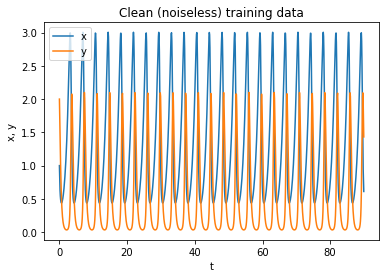

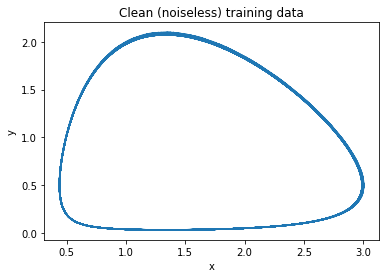

In [4]:
title = "Clean (noiseless) training data"
time_plot(t, x, title)
phase_plot(x, title)

In [5]:
def get_model():
    model = ps.SINDy(
    differentiation_method = ps.FiniteDifference(order=2),
        feature_library = ps.PolynomialLibrary(degree=3),
        optimizer = ps.STLSQ(threshold=0.2),
        feature_names=["x", "y"]
    )
    return(model)

In [6]:
model = get_model()
model.fit(x, t=dt)
model.print()

(x)' = 0.983 x + -1.965 x y
(y)' = -3.893 y + 2.919 x y


In [7]:
x0_test = [1, 1.5]
t_test = t
t_span_test = t_span
x_test = solve_ivp(predator_prey, t_span_test, x0_test, t_eval=t_test, **integrator_keywords).y.T

sim = model.simulate(x0_test, t=t_test)

In [8]:
def comparison_plot(x, sim, main_str):
    plt.plot(x[0,0], x[0,1], "ro", label="Initial condition", alpha=0.6, markersize=8)
    plt.plot(x[:,0], x[:,1], "b", label="Exact solution", alpha=0.4, linewidth=1)
    plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(main_str)
    plt.show()

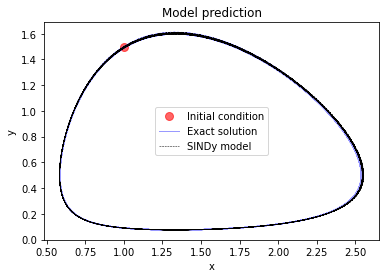

In [9]:
comparison_plot(x_test, sim, "Model prediction")

In [10]:
def noisify(x, sd):
    norm_sigma = np.sqrt(np.log(1+sd**2))
    norm_mu = -norm_sigma**2/2
    return(np.multiply(np.random.lognormal(norm_mu, norm_sigma, x.shape), x))

In [17]:
sd = 0.02
x_noisy = noisify(x, sd)
model_noisy = get_model()
model_noisy.fit(x_noisy, t=dt)
model_noisy.print()

(x)' = 1.042 x + 0.635 y + -3.968 x y + 0.463 x^2 y + 0.412 x y^2
(y)' = -3.890 y + 2.915 x y


In [18]:
model.print()

(x)' = 0.983 x + -1.965 x y
(y)' = -3.893 y + 2.919 x y


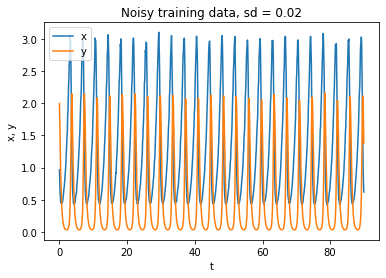

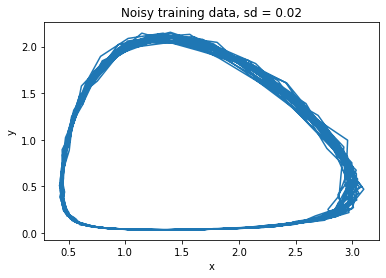

In [19]:
title = f'Noisy training data, sd = {sd}'
time_plot(t, x_noisy, title)
phase_plot(x_noisy, title)

In [20]:
sim_noisy = model_noisy.simulate(x0_test, t=t_test)
x_noisy_test = solve_ivp(predator_prey, t_span_test, x0_test, t_eval=t_test, **integrator_keywords).y.T

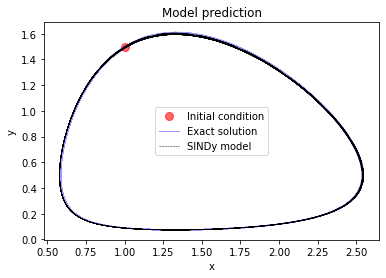

In [16]:
comparison_plot(x_noisy_test, sim_noisy, "Model prediction")